# AMI Postprocessing

This example demonstrates advanced postprocessing of AMI simulations.

Keywords: **Circuit**, **AMI**.

## Perform imports and define constants

Perform required imports.

> **Note:** [Numpy](https://numpy.org/)
> and [Matplotlib](https://matplotlib.org/) are required to run this example.

In [1]:
import os
import tempfile
import time

import ansys.aedt.core
import numpy as np
from matplotlib import pyplot as plt


Define constants.

In [2]:
AEDT_VERSION = "2024.2"
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory and download example files

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [3]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

## Download example data

The ``download_file()`` method retrieves example
data from the PyAnsys
[example-data](https://github.com/ansys/example-data/tree/master/pyaedt) repository.

- The fist argument is the folder name where
  the example files are located in the GitHub repository.
- The 2nd argument is the file to retrieve.
- The 3rd argument is the destination folder.

Files are placed in the destination folder.

In [4]:
project_path = ansys.aedt.core.downloads.download_file(
    "ami", name="ami_usb.aedtz", destination=temp_folder.name
)

## Launch AEDT with Circuit and enable Pandas as the output format

All outputs obtained with the `get_solution_data()` method are in the
[Pandas](https://pandas.pydata.org/docs/user_guide/index.html) format.
Launch AEDT with Circuit. The `ansys.aedt.core.Desktop` class initializes AEDT
and starts the specified version in the specified mode.

In [5]:
ansys.aedt.core.settings.enable_pandas_output = True
circuit = ansys.aedt.core.Circuit(
    project=os.path.join(project_path),
    non_graphical=NG_MODE,
    version=AEDT_VERSION,
    new_desktop=True,
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_d6c6179e-9738-4198-bfde-a19f211a2a1c.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 60340


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 1388.


PyAEDT INFO: Archive C:\Users\ansys\AppData\Local\Temp\tmp67l0pijl.ansys\ami\ami_usb.aedtz has been restored to project Project_YVT


PyAEDT INFO: Active Design set to 0;Circuit1


PyAEDT INFO: Aedt Objects correctly read


## Solve AMI setup

Solve the transient setup.

In [6]:
circuit.analyze()

PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Circuit Design correctly changed.


PyAEDT INFO: Solving all design setups.


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Circuit Design correctly changed.


PyAEDT INFO: Design setup None solved correctly in 0.0h 0.0m 21.0s


True

## Get AMI report

Get AMI report data.

In [7]:
plot_name = "WaveAfterProbe<b_input_43.int_ami_rx>"
circuit.solution_type = "NexximAMI"
original_data = circuit.post.get_solution_data(
    expressions=plot_name,
    setup_sweep_name="AMIAnalysis",
    domain="Time",
    variations=circuit.available_variations.nominal,
)
original_data_value = original_data.full_matrix_real_imag[0]
original_data_sweep = original_data.primary_sweep_values
print(original_data_value)

PyAEDT INFO: ModelerCircuit class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: ModelerNexxim class has been initialized!


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Solution Data Correctly Loaded.


           WaveAfterProbe<b_input_43.int_ami_rx>
0.000000                             -553.298382
0.003125                             -553.298382
0.006250                             -553.298382
0.009375                             -553.298382
0.012500                             -553.298382
...                                          ...
99.984375                             -25.138119
99.987500                              19.046320
99.990625                              60.268984
99.993750                              98.348353
99.996875                             133.328724

[32000 rows x 1 columns]


## Plot data

Create a plot based on solution data.

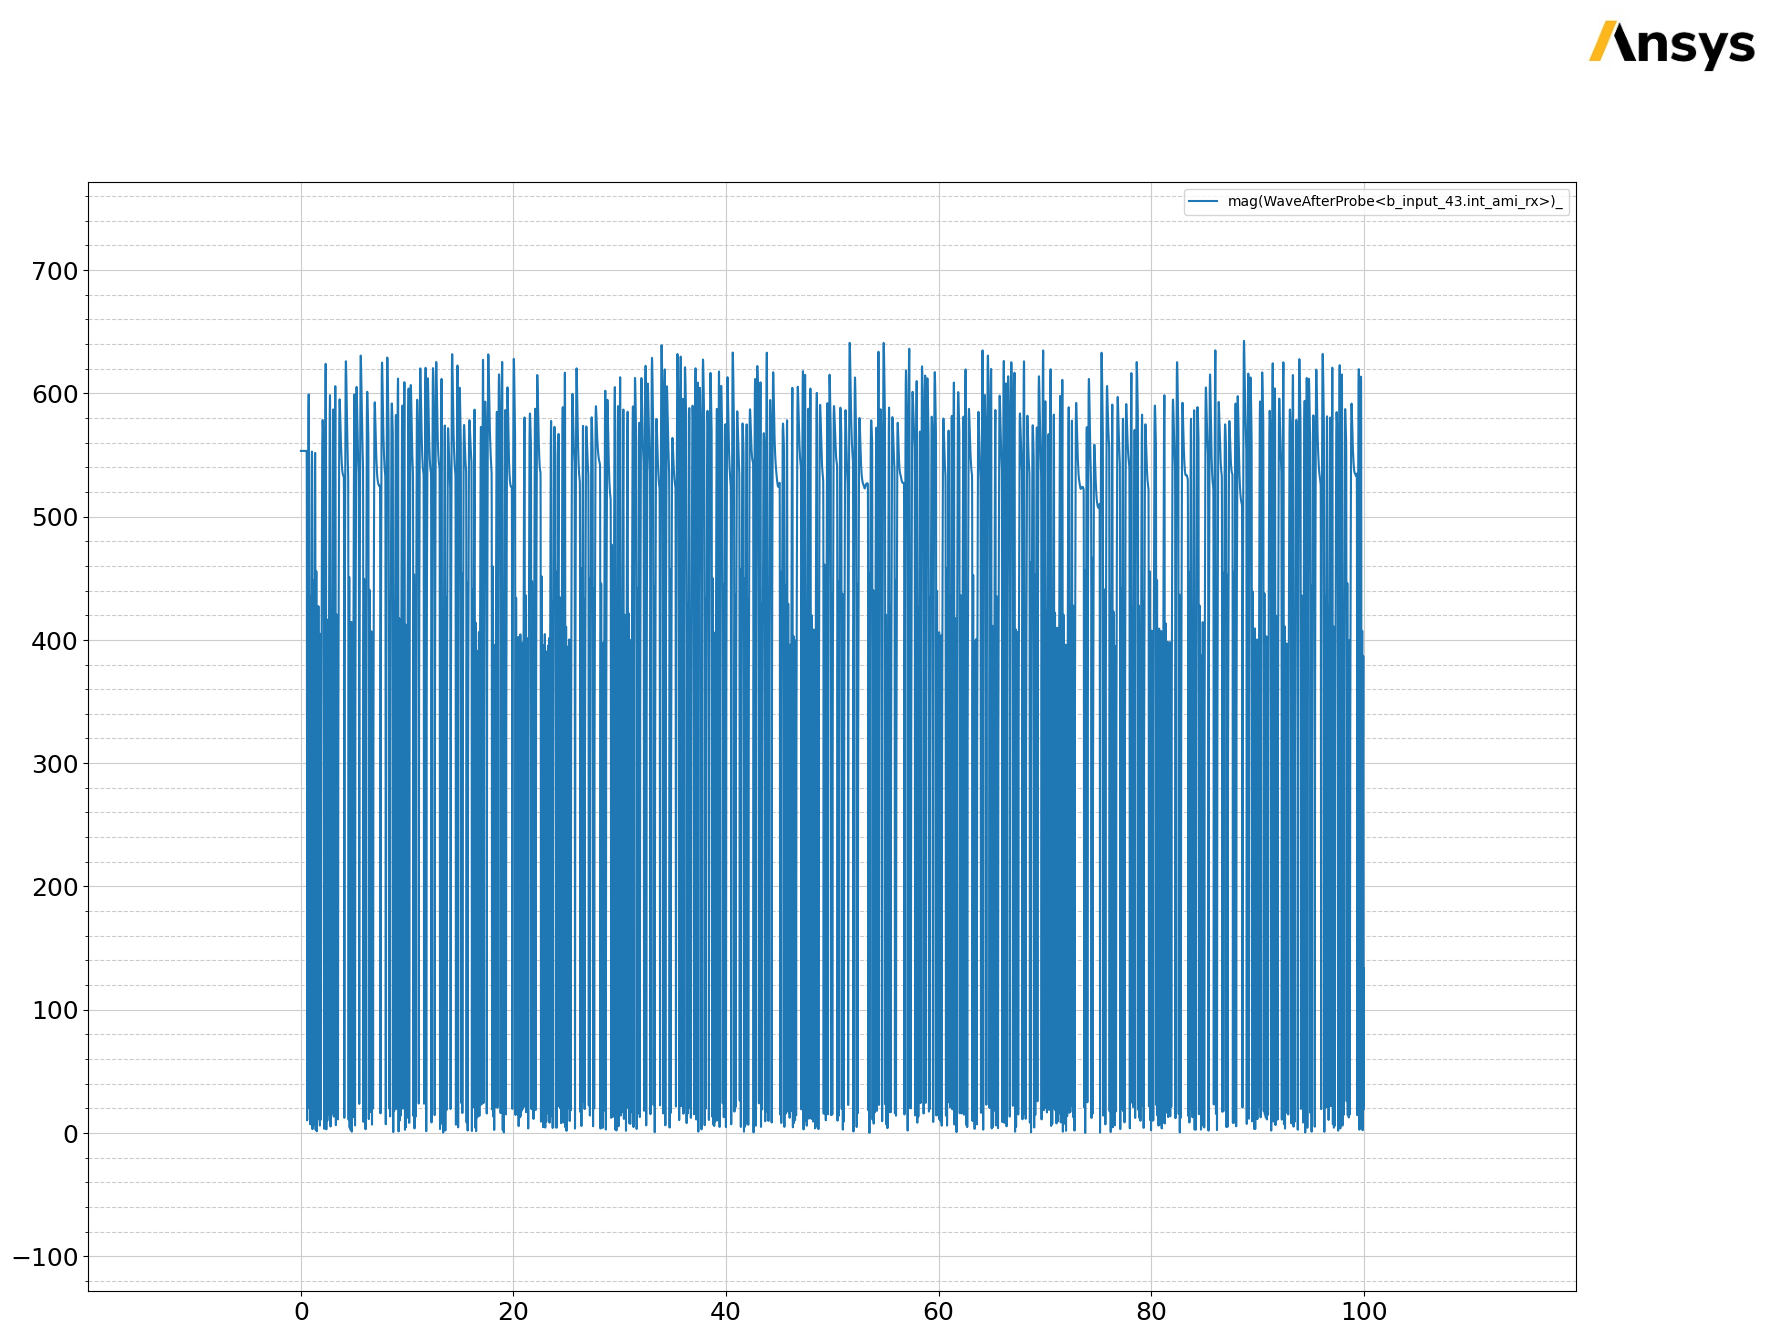

In [8]:
fig = original_data.plot()

## Extract wave form

Use the ``WaveAfterProbe`` plot type to extract the
waveform using an AMI receiver clock probe.
The signal is extracted at a specific clock
flank with additional half unit interval.

In [9]:
probe_name = "b_input_43"
source_name = "b_output4_42"
plot_type = "WaveAfterProbe"
setup_name = "AMIAnalysis"
ignore_bits = 100
unit_interval = 0.1e-9
sample_waveform = circuit.post.sample_ami_waveform(
    setup=setup_name,
    probe=probe_name,
    source=source_name,
    variation_list_w_value=circuit.available_variations.nominal,
    unit_interval=unit_interval,
    ignore_bits=ignore_bits,
    plot_type=plot_type,
)

PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Solution Data Correctly Loaded.


## Plot waveform and samples

Create the plot from a start time to stop time in seconds.

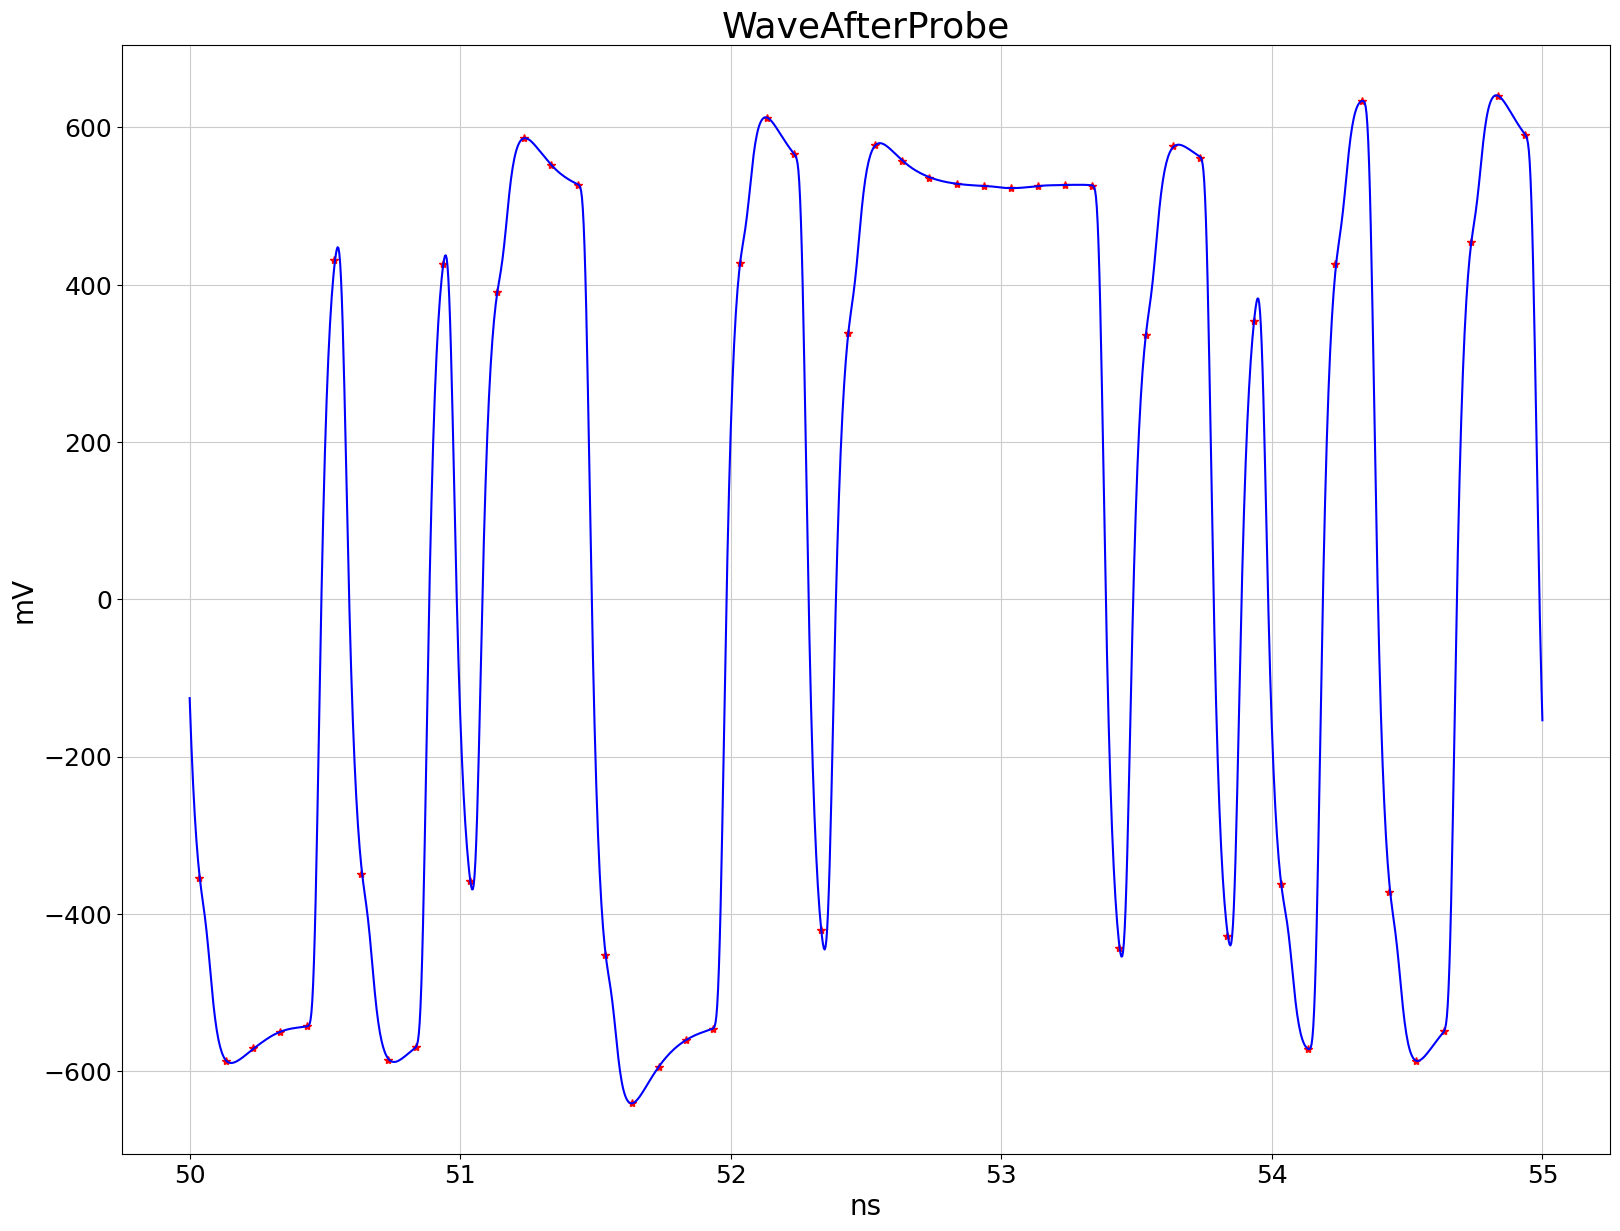

In [10]:
tstop = 55e-9
tstart = 50e-9
scale_time = ansys.aedt.core.constants.unit_converter(
    1,
    unit_system="Time",
    input_units="s",
    output_units=original_data.units_sweeps["Time"],
)
scale_data = ansys.aedt.core.constants.unit_converter(
    1,
    unit_system="Voltage",
    input_units="V",
    output_units=original_data.units_data[plot_name],
)

tstop_ns = scale_time * tstop
tstart_ns = scale_time * tstart

for time_value in original_data_value[plot_name].index:
    if tstart_ns <= time_value[0]:
        start_index_original_data = time_value[0]
        break
for time_value in original_data_value[plot_name][start_index_original_data:].index:
    if time_value[0] >= tstop_ns:
        stop_index_original_data = time_value[0]
        break
for time_value in sample_waveform[0].index:
    if tstart <= time_value:
        sample_index = sample_waveform[0].index == time_value
        start_index_waveform = sample_index.tolist().index(True)
        break
for time_value in sample_waveform[0].index:
    if time_value >= tstop:
        sample_index = sample_waveform[0].index == time_value
        stop_index_waveform = sample_index.tolist().index(True)
        break

original_data_zoom = original_data_value[
    start_index_original_data:stop_index_original_data
]
sampled_data_zoom = (
    sample_waveform[0].values[start_index_waveform:stop_index_waveform] * scale_data
)
sampled_time_zoom = (
    sample_waveform[0].index[start_index_waveform:stop_index_waveform] * scale_time
)

fig, ax = plt.subplots()
ax.plot(sampled_time_zoom, sampled_data_zoom, "r*")
ax.plot(
    np.array(list(original_data_zoom.index.values)),
    original_data_zoom.values,
    color="blue",
)
ax.set_title("WaveAfterProbe")
ax.set_xlabel(original_data.units_sweeps["Time"])
ax.set_ylabel(original_data.units_data[plot_name])
plt.show()

## Plot slicer scatter

Create the plot from a start time to stop time in seconds.

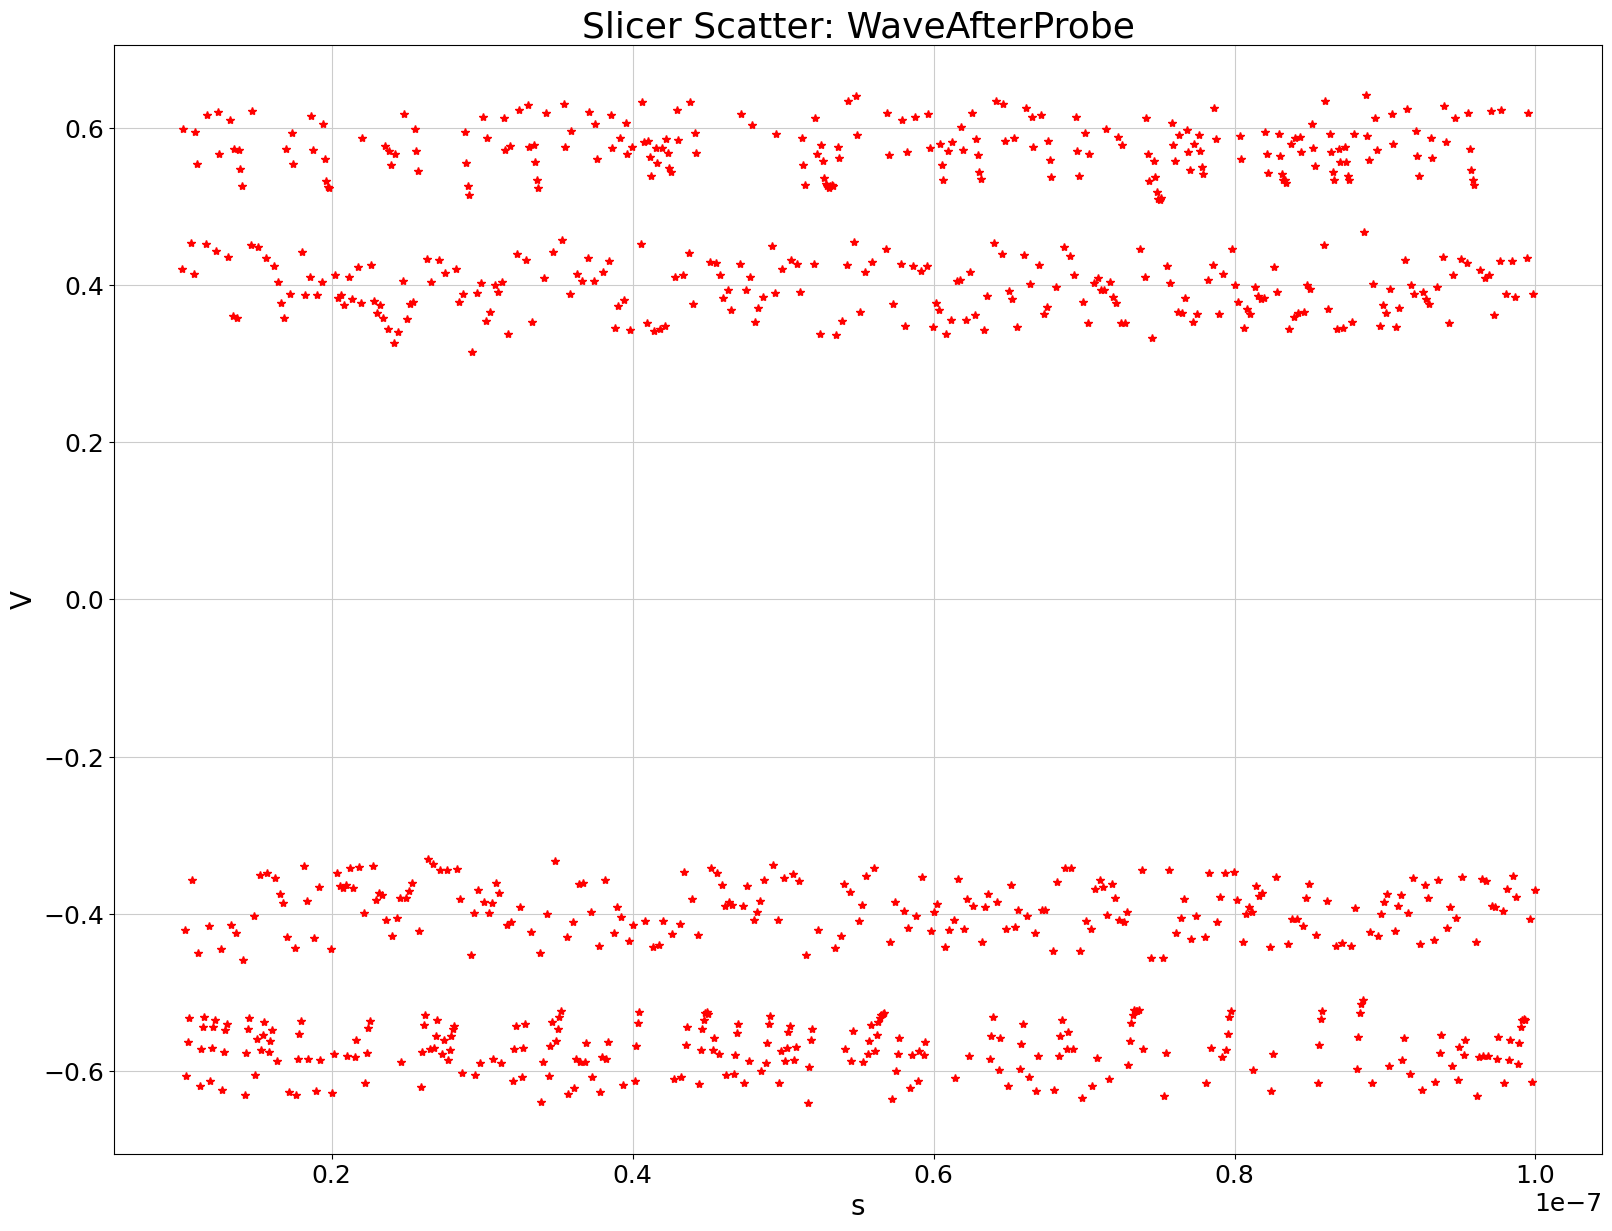

In [11]:
fig, ax2 = plt.subplots()
ax2.plot(sample_waveform[0].index, sample_waveform[0].values, "r*")
ax2.set_title("Slicer Scatter: WaveAfterProbe")
ax2.set_xlabel("s")
ax2.set_ylabel("V")
plt.show()

## Plot scatter histogram

Create the plot from a start time to stop time in seconds.

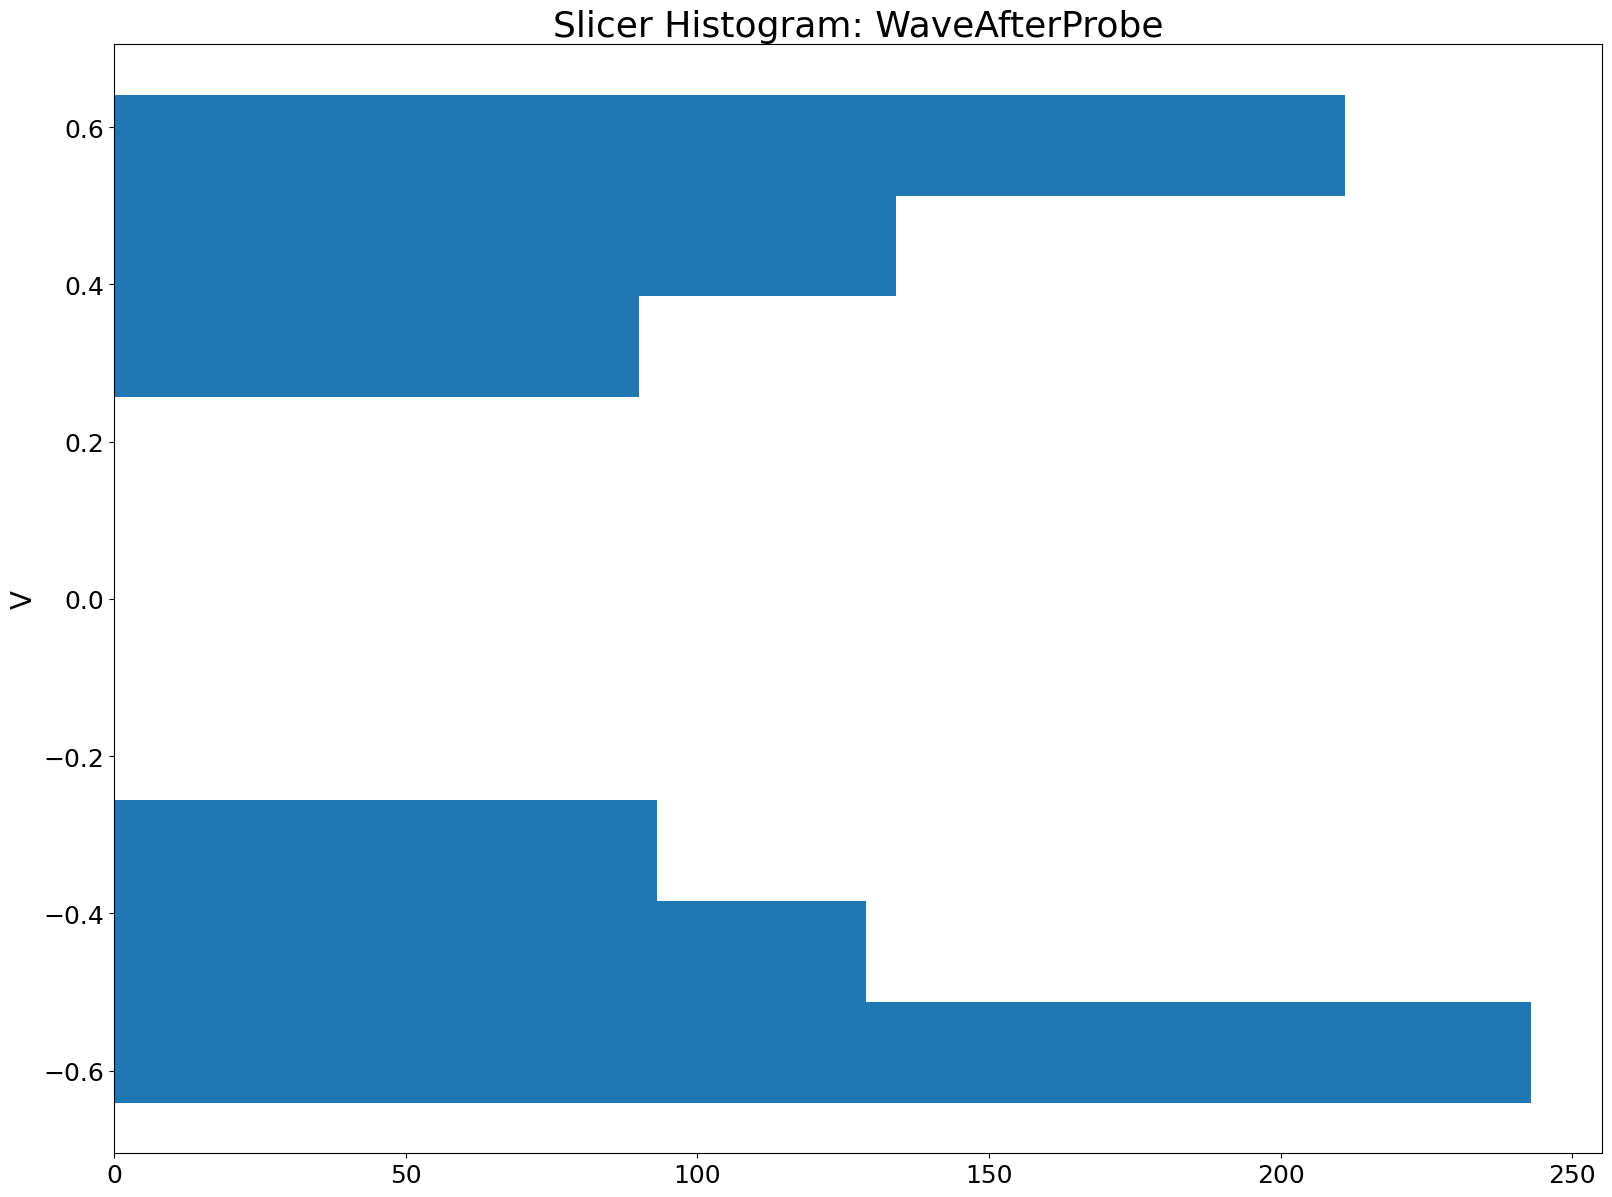

In [12]:
fig, ax4 = plt.subplots()
ax4.set_title("Slicer Histogram: WaveAfterProbe")
ax4.hist(sample_waveform[0].values, orientation="horizontal")
ax4.set_ylabel("V")
ax4.grid()
plt.show()

## Get transient report data

In [13]:
plot_name = "V(b_input_43.int_ami_rx.eye_probe.out)"
circuit.solution_type = "NexximTransient"
original_data = circuit.post.get_solution_data(
    expressions=plot_name,
    setup_sweep_name="NexximTransient",
    domain="Time",
    variations=circuit.available_variations.nominal,
)

PyAEDT INFO: Solution Data Correctly Loaded.


## Extract sample waveform

Extract a waveform at a specific clock time plus a half unit interval.

In [14]:
original_data.enable_pandas_output = False
original_data_value = original_data.data_real()
original_data_sweep = original_data.primary_sweep_values
waveform_unit = original_data.units_data[plot_name]
waveform_sweep_unit = original_data.units_sweeps["Time"]
tics = np.arange(20e-9, 100e-9, 1e-10, dtype=float)

sample_waveform = circuit.post.sample_waveform(
    waveform_data=original_data_value,
    waveform_sweep=original_data_sweep,
    waveform_unit=waveform_unit,
    waveform_sweep_unit=waveform_sweep_unit,
    unit_interval=unit_interval,
    clock_tics=tics,
    pandas_enabled=False,
)

## Plot waveform

Create the plot from a start time to stop time in seconds.

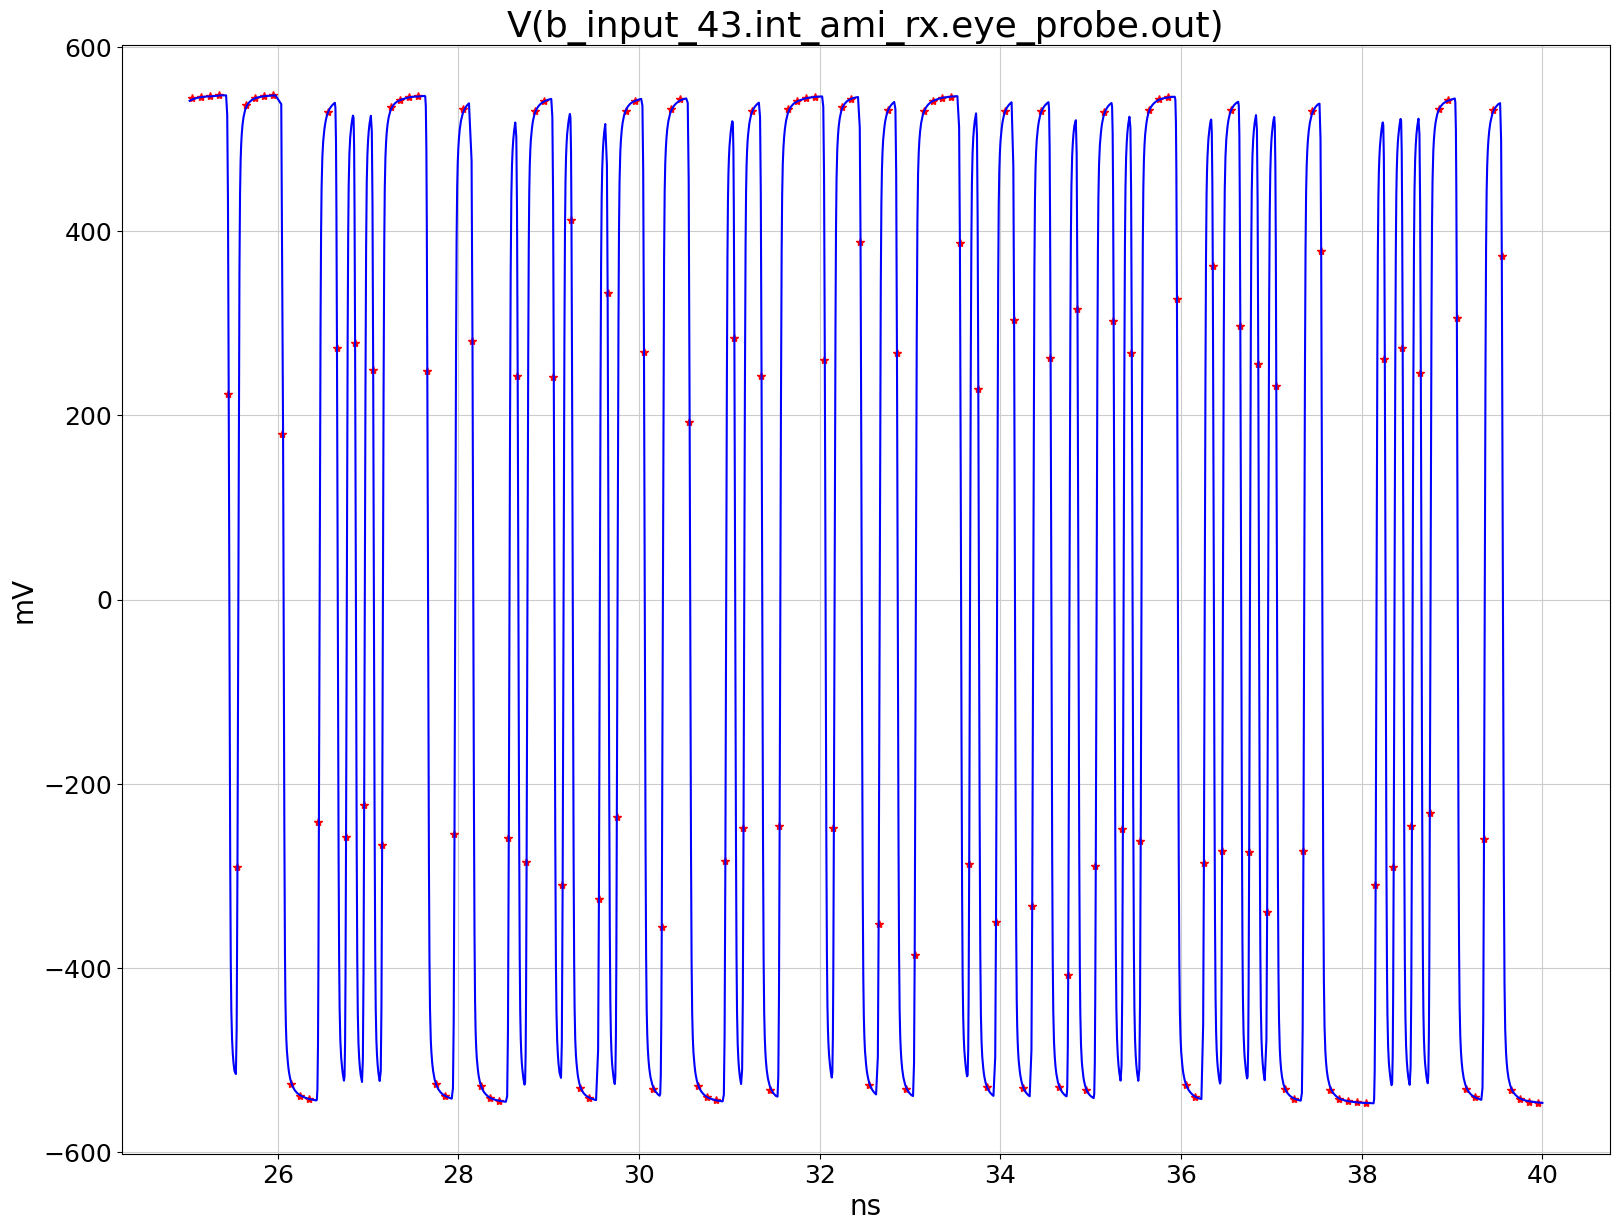

In [15]:
tstop = 40.0e-9
tstart = 25.0e-9
scale_time = ansys.aedt.core.constants.unit_converter(
    1, unit_system="Time", input_units="s", output_units=waveform_sweep_unit
)
scale_data = ansys.aedt.core.constants.unit_converter(
    1, unit_system="Voltage", input_units="V", output_units=waveform_unit
)

tstop_ns = scale_time * tstop
tstart_ns = scale_time * tstart

for time_value in original_data_sweep:
    if tstart_ns <= time_value:
        start_index_original_data = original_data_sweep.index(time_value)
        break
for time_value in original_data_sweep[start_index_original_data:]:
    if time_value >= tstop_ns:
        stop_index_original_data = original_data_sweep.index(time_value)
        break
cont = 0
for frame in sample_waveform:
    if tstart <= frame[0]:
        start_index_waveform = cont
        break
    cont += 1
for frame in sample_waveform[start_index_waveform:]:
    if frame[0] >= tstop:
        stop_index_waveform = cont
        break
    cont += 1

original_data_zoom = original_data_value[
    start_index_original_data:stop_index_original_data
]
original_sweep_zoom = original_data_sweep[
    start_index_original_data:stop_index_original_data
]
original_data_zoom_array = np.array(
    list(map(list, zip(original_sweep_zoom, original_data_zoom)))
)
original_data_zoom_array[:, 0] *= 1
sampled_data_zoom_array = np.array(
    sample_waveform[start_index_waveform:stop_index_waveform]
)
sampled_data_zoom_array[:, 0] *= scale_time
sampled_data_zoom_array[:, 1] *= scale_data

fig, ax = plt.subplots()
ax.plot(sampled_data_zoom_array[:, 0], sampled_data_zoom_array[:, 1], "r*")
ax.plot(original_sweep_zoom, original_data_zoom_array[:, 1], color="blue")
ax.set_title(plot_name)
ax.set_xlabel(waveform_sweep_unit)
ax.set_ylabel(waveform_unit)
plt.show()

## Plot slicer scatter

Create the plot from a start time to stop time in seconds.

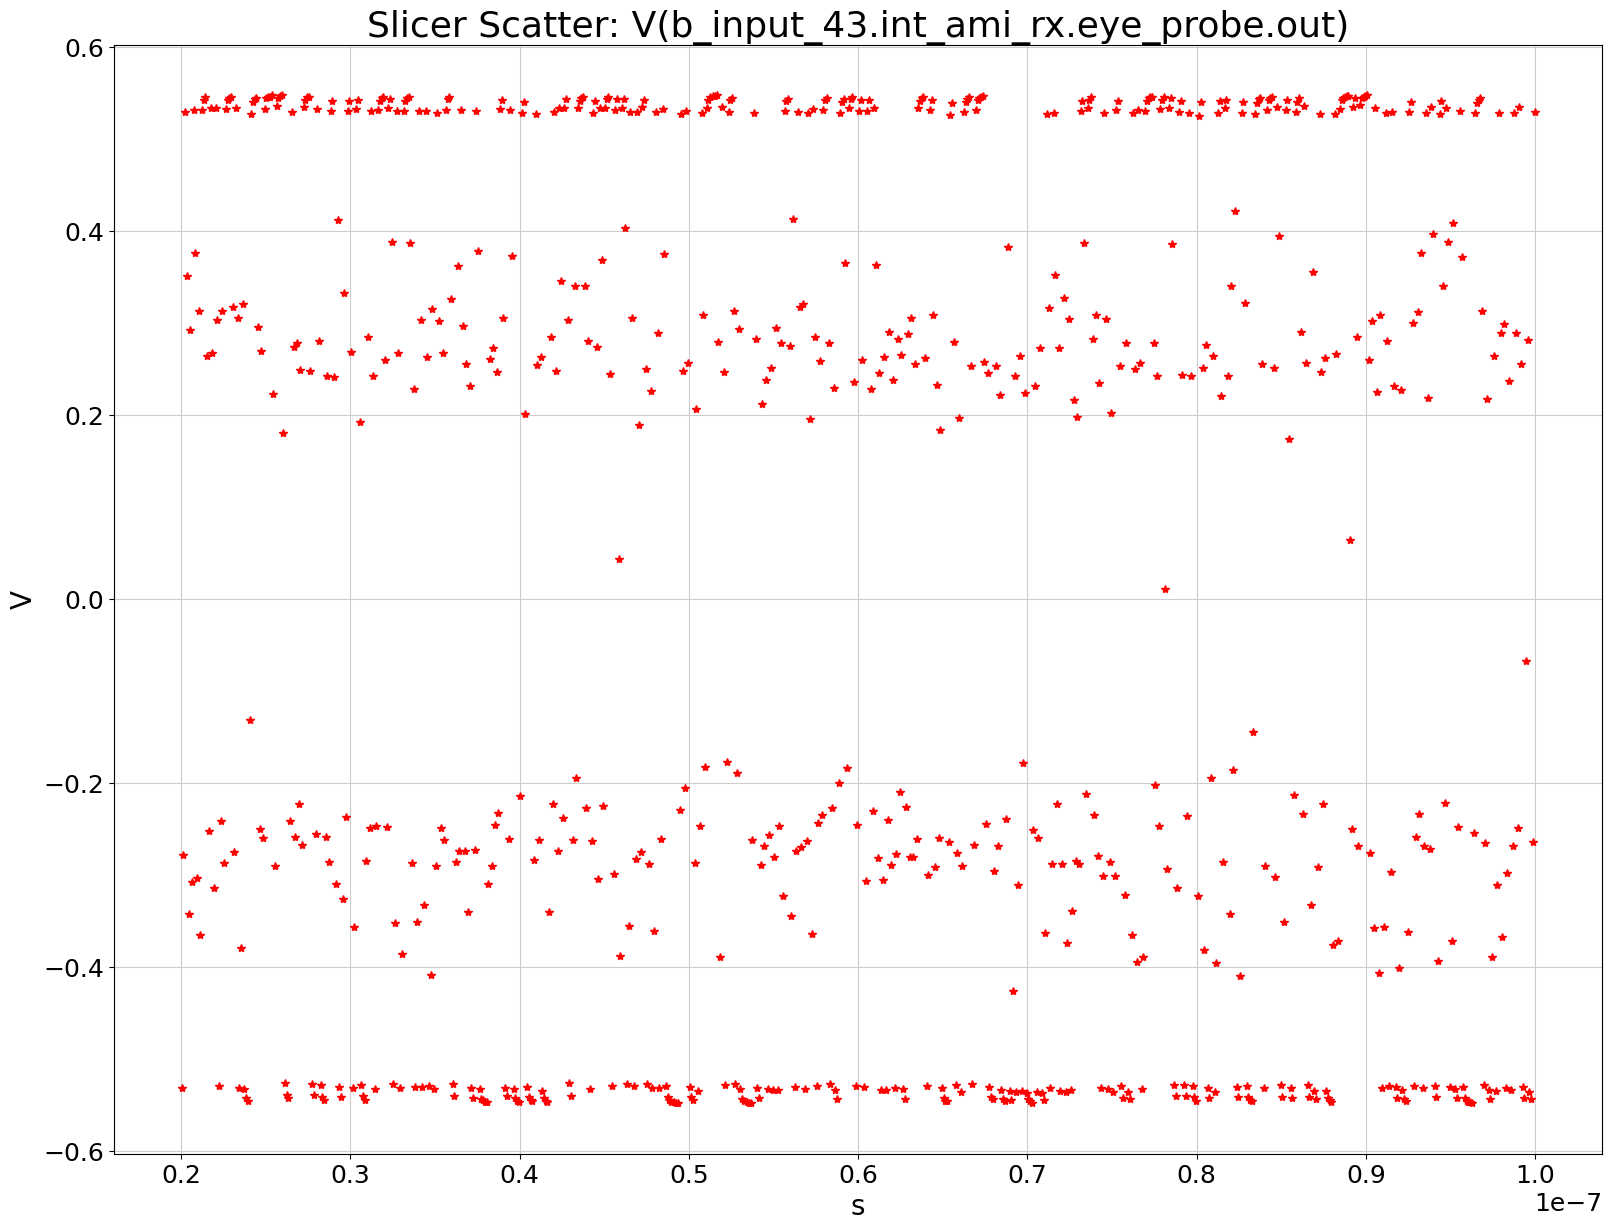

In [16]:
sample_waveform_array = np.array(sample_waveform)
fig, ax2 = plt.subplots()
ax2.plot(sample_waveform_array[:, 0], sample_waveform_array[:, 1], "r*")
ax2.set_title("Slicer Scatter: " + plot_name)
ax2.set_xlabel("s")
ax2.set_ylabel("V")
plt.show()

## Release AEDT

Release AEDT and close the example.

In [17]:
circuit.save_project()
circuit.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project Project_YVT Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``. If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell removes all temporary files, including the project folder.

In [18]:
temp_folder.cleanup()